In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
old_file = 'SD.csv'
old = pd.read_csv(old_file)

file = 'filtered_data.csv'
df = pd.read_csv(file)


print(len(old))
print(len(df))

991346
595460


Summary Statistics

In [ ]:
display(df.describe())

Datatypes

In [ ]:
df.info()

In [ ]:
print(df.isnull().sum())
# No null values but in case there were:
df = df.dropna()

In [ ]:
# Calculate and display outliers using IQR method for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"{col}:")
    print(f"  Outlier count: {len(outliers)}")
    print(f"  Outlier percentage: {len(outliers)/len(df)*100:.2f}%")
    print(f"  Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    if len(outliers) > 0:
        print(f"  Min outlier: {outliers[col].min():.2f}")
        print(f"  Max outlier: {outliers[col].max():.2f}")
    print()

In [ ]:
# Create visualizations for outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:12]):  # Show first 12 numerical columns
    # Calculate outlier bounds for this column
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create box plot
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col} - Outliers Detection')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create additional plots for remaining numerical columns if any
if len(numerical_cols) > 12:
    remaining_cols = numerical_cols[12:]
    n_remaining = len(remaining_cols)
    n_cols = 4
    n_rows = (n_remaining + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_remaining == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(remaining_cols):
        sns.boxplot(data=df, y=col, ax=axes[i])
        axes[i].set_title(f'{col} - Outliers Detection')
        axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Variable groups from dataset documentation ---
CONTINUOUS_VARS = [
    "age", "height", "weight", "sight_left", "sight_right",
    "SBP", "DBP", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
    "triglyceride", "hemoglobin", "serum_creatinine",
    "SGOT_AST", "SGOT_ALT", "gamma_GTP", "waistline"
]

ORDINAL_VARS = ["urine_protein"]  # exclude from IQR
CATEGORICAL_VARS = ["sex", "hear_left", "hear_right", "SMK_stat_type_cd", "DRK_YN"]

# Use intersection with actual columns
cont_cols = [c for c in CONTINUOUS_VARS if c in df.columns]

def iqr_bounds(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return low, high

In [ ]:
# Remove (clear errors)

df_clean = df.copy()

REMOVE_RULES = {
    "waistline": lambda s: s > 200,  # e.g., 1000 cm entries
    "serum_creatinine": lambda s: s > 20,  # mg/dL, implausible highs
    "SGOT_AST": lambda s: s > 9000,  # extreme enzyme typos
    "SGOT_ALT": lambda s: s > 9000,
    "sight_left": lambda s: s >= 5,  # 10.0 eyesight entries -> remove
    "sight_right": lambda s: s >= 5,
}

# Apply removal rules
mask_keep = pd.Series(True, index=df_clean.index)
remove_report = []
for col, rule in REMOVE_RULES.items():
    if col in df_clean.columns:
        bad = rule(pd.to_numeric(df_clean[col], errors="coerce"))
        n_bad = int(bad.sum())
        if n_bad > 0:
            mask_keep &= ~bad
            remove_report.append((col, n_bad))

df_clean = df_clean.loc[mask_keep]
print("Rows removed (by column):", remove_report)

# =========================
# 2) CAP (winsorize at IQR)
# =========================
cap_report = []
for col in cont_cols:
    if col in df_clean.columns:
        low, high = iqr_bounds(df_clean[col])
        before = pd.to_numeric(df_clean[col], errors="coerce")
        n_low = int((before < low).sum())
        n_high = int((before > high).sum())
        df_clean[col] = before.clip(lower=low, upper=high)
        cap_report.append({
            "column": col,
            "capped_low": n_low,
            "capped_high": n_high
        })

print(pd.DataFrame(cap_report))

# ==============================
# 3) TRANSFORM (reduce skew with log1p)
# ==============================
LOG1P_VARS = [
    v for v in [
        "weight", "BLDS", "tot_chole", "HDL_chole", "LDL_chole",
        "triglyceride", "SGOT_AST", "SGOT_ALT", "gamma_GTP"
    ]
    if v in df_clean.columns
]

transform_report = []
for col in LOG1P_VARS:
    x = pd.to_numeric(df_clean[col], errors="coerce")
    n_neg = int((x < 0).sum())
    if n_neg:
        x = x.clip(lower=0)  # ensure non-negative before log1p
    df_clean[col] = np.log1p(x)
    transform_report.append({
        "column": col,
        "negatives_clipped": n_neg
    })

print(pd.DataFrame(transform_report))


SGOT_AST            165.738259
serum_creatinine    112.288906
SGOT_ALT             60.296041
sight_right          10.750844
sight_left           10.681968
gamma_GTP             7.402068
hear_right            6.635844
hear_left             6.515628
triglyceride          5.980332
urine_protein         5.755595
BLDS                  4.461389
LDL_chole             2.516334
waistline             1.811748
HDL_chole             1.785216
tot_chole             1.596834
SMK_stat_type_cd      0.781870
weight                0.492069
SBP                   0.463492
DBP                   0.378413
age                   0.077789
height                0.058596
hemoglobin           -0.441448
dtype: float64
Highly skewed features: ['SGOT_AST', 'serum_creatinine', 'SGOT_ALT', 'sight_right', 'sight_left', 'gamma_GTP', 'hear_right', 'hear_left', 'triglyceride', 'urine_protein', 'BLDS', 'LDL_chole', 'waistline', 'HDL_chole', 'tot_chole']


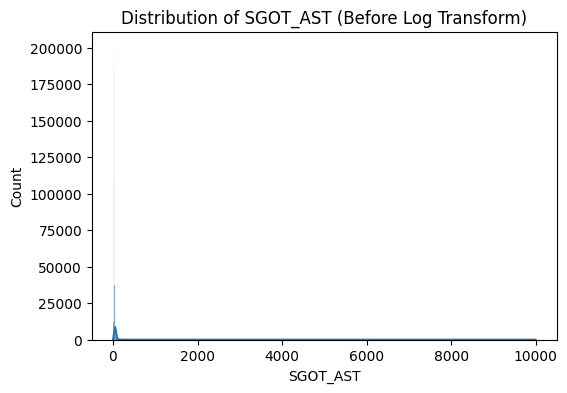

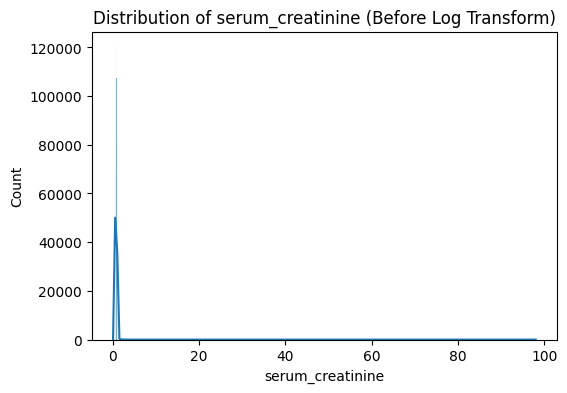

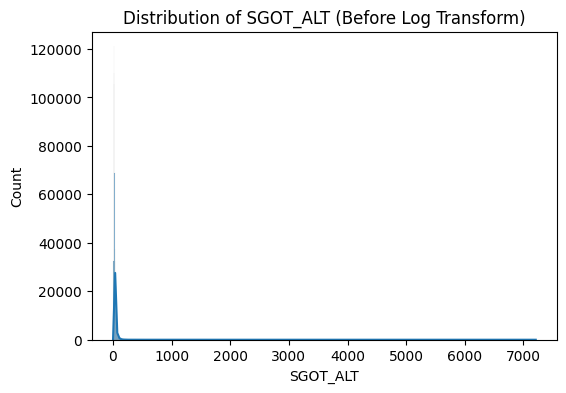

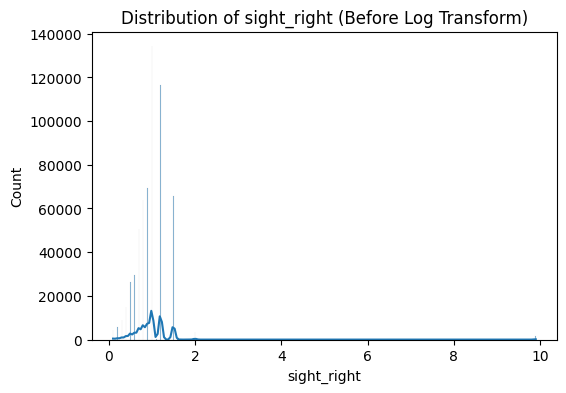

In [ ]:
# Numerical features only
num_cols = df.select_dtypes(include=[np.number]).columns

# Compute skewness
skew_vals = df[num_cols].skew().sort_values(ascending=False)
print(skew_vals)

# Visualize highly skewed features (top 4 for example)
high_skew = skew_vals[skew_vals > 1].index.tolist()
print("Highly skewed features:", high_skew)

for col in high_skew[:4]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (Before Log Transform)")
    plt.show()

Skewness after log transform:
hear_right          6.635844
hear_left           6.515628
urine_protein       4.840889
serum_creatinine    3.021519
BLDS                2.034012
SGOT_AST            1.482175
sight_left          1.447070
sight_right         1.406086
gamma_GTP           0.987817
SGOT_ALT            0.774939
triglyceride        0.405478
HDL_chole          -0.029394
waistline          -0.112067
tot_chole          -0.266684
LDL_chole          -1.090736
dtype: float64


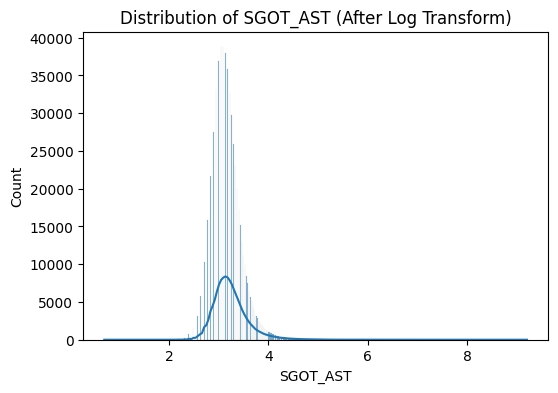

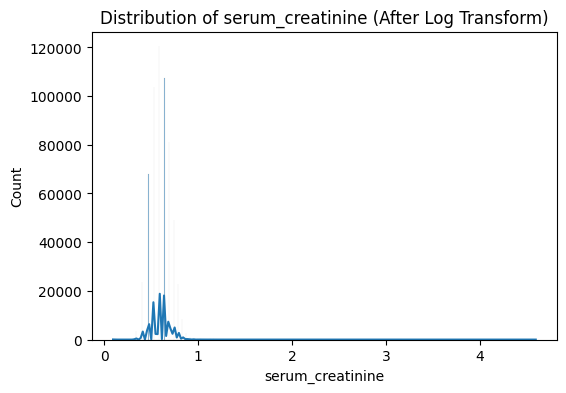

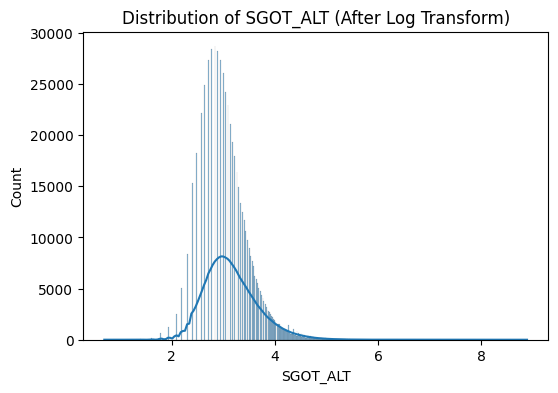

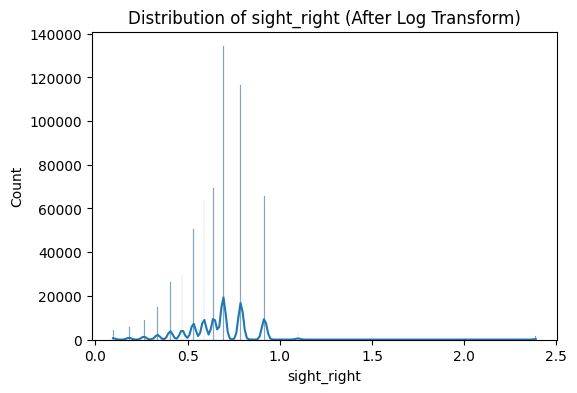

In [ ]:
# Apply log1p to highly skewed features
for col in high_skew:
    df[col] = np.log1p(df[col])

# Recompute skewness after transformation
skew_after = df[high_skew].skew().sort_values(ascending=False)
print("Skewness after log transform:")
print(skew_after)

# Optional visualization after
for col in high_skew[:4]:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col} (After Log Transform)")
    plt.show()

Feature extraction after stabilizing data:

In [ ]:
df['BMI'] = df['weight'] / (df['height']/100)**2
df['pulse_pressure'] = df['SBP'] - df['DBP']
df['LDL_to_HDL'] = df['LDL_chole'] / df['HDL_chole']
df['TG_to_HDL'] = df['triglyceride'] / df['HDL_chole']
df['sight_avg'] = (df['sight_left'] + df['sight_right']) / 2
df['hearing_avg'] = (df['hear_left'] + df['hear_right']) / 2